### 스토캐스틱(Stochastic)
* 스토캐스틱 오실레이터( stochastic oscillator)
    -  RSI 와 더불어 모멘텀 지표 중 가장 많이 사용하는 지표
    - 수식이 간단하고 의미를 파악하기가 쉬우며 그 쉬움에 비해 쓸만하기에 많은 트레이더들이 사용
* 원리
    - RSI 와 마찬가지로 기간과 가격만을 사용하여 계산
    - 최근 N일간의 최고가와 최저가의 범위 내에서 현재 가격의 위치를 표시할때, 
    - 매수세가 매도세보다 강할 때는 그 위치가 높게 형성되고, 
    - 매도세가 매수세보다 강할 때는 그 위치가 낮게 형성된다는 것을 이용한 것
* 주식가격의 표준지표화
    - %K 스토캐스틱N = (현재 가격 - N일중 최저가)/(N일중 최고가 - N일중 최저가)
        - 해당 기간동안 최고가와 최저가의 차이 대비 현재가격과 최저가의 차이를 비율로 표현
    - %D 스토캐스틱N의 이평선: 스토캐스틱의 시그널
        - %K 의 n 일 이동평균선이며 %K 보다 가격 변화에 대해 반응이 늦기에 slow %K 라고도함

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def seldata(cols=['sday','sclose'],where='where sday>"2022-01-01" order by sday asc'): # where 조건으로 날짜 지정
    fname='_db/nstock.db'
    with sqlite3.connect(fname) as conn: # 사용할 SQLite DB파일 오픈
        cur=conn.cursor() # cursor 생성
        coltxt=','.join(cols)
        sql='select '+coltxt+' from stockdb '+where # sql 쿼리 작성
        print(sql)
        res=cur.execute(sql).fetchall()  # sql쿼리 실행
    return res

res=seldata()
res[:5]

select sday,sclose from stockdb where sday>"2022-01-01" order by sday asc


[('2022-01-03', 128500),
 ('2022-01-04', 128500),
 ('2022-01-05', 125500),
 ('2022-01-06', 125000),
 ('2022-01-07', 127000)]

In [3]:
cols=['sday','sclose']
df = pd.DataFrame(res,columns=cols)
mdf=df.set_index('sday')
mdf.tail()

,sclose
sday,
2022-05-06,107500
2022-05-09,107500
2022-05-10,110000
2022-05-11,110500
2022-05-12,110500


In [16]:
N=5
sig=3
Slowsig=3
mdf['SMAX']=mdf['sclose'].rolling(window=N).max()
mdf['SMIN']=mdf['sclose'].rolling(window=N).min()
stk=(mdf['sclose']-mdf['SMIN'])/(mdf['SMAX']-mdf['SMIN']+0.000001)

### 패스트 스토캐스틱 %K 와 %D를 직접 사용
mdf['STK']=np.round(stk,2)
sdf=mdf.fillna(0)
sdf['STD']=sdf['STK'].rolling(window=sig).mean()
sdf=sdf.fillna(0)

### 슬로우 스토캐스틱
sdf['slowK']=sdf['STK'].rolling(window=Slowsig).mean()
sdf['slowD']=sdf['slowK'].rolling(window=Slowsig).mean()
sdf=sdf.fillna(0)
sdf.head()

,sclose,SMAX,SMIN,STK,STD,slowK,slowD
sday,,,,,,,
2022-01-03,128500,0.0,0.0,0.00,0.00,0.00,0.000000
2022-01-04,128500,0.0,0.0,0.00,0.00,0.00,0.000000
2022-01-05,125500,0.0,0.0,0.00,0.00,0.00,0.000000
2022-01-06,125000,0.0,0.0,0.00,0.00,0.00,0.000000
2022-01-07,127000,128500.0,125000.0,0.57,0.19,0.19,0.063333


<AxesSubplot:xlabel='sday'>

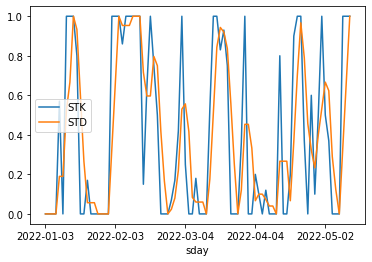

In [18]:
sdf[['STK','STD']].plot()

<AxesSubplot:xlabel='sday'>

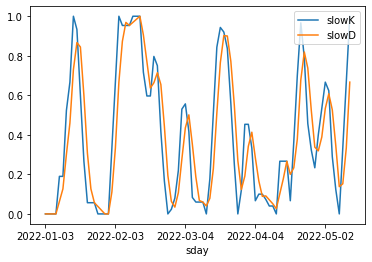

In [19]:
sdf[['slowK','slowD']].plot()

In [20]:
def simStock(mdf,stxt='shortmv',ltxt='longmv'):
    findex=mdf.iloc[:1,:].index[0]
    lindex=mdf.iloc[-1:,:].index[0]
    lindex
    invest=200000
    beforePos=-1
    beforeHold=0

    for i,row in mdf.iloc[10:,:].iterrows():
        if(row[stxt]>=row[ltxt]):
            nowpos=1 # short 상위
        else:
            nowpos=-1 # short 하위
        if beforePos==-1 and nowpos==1 and beforeHold==0:
            timing=1# 매수타이밍
            hold=1
            mdf.loc[i,'cash']=-row['sclose']
            mdf.loc[i,'hold']=1
        elif beforePos==1 and nowpos==-1 and beforeHold==1:
            timing=-1# 매수타이밍
            hold=0
            mdf.loc[i,'cash']=row['sclose']
            mdf.loc[i,'hold']=0
        else:
            mdf.loc[i,'cash']=0
            timing=0 # 홀드
            hold=beforeHold
            mdf.loc[i,'hold']=beforeHold
        beforeHold=hold
        beforePos=nowpos
        mdf.loc[findex,'cash']=invest
        mdf['cumcash']=mdf['cash'].cumsum()
        mdf['balalce']=mdf['sclose']*mdf['hold']+mdf['cumcash']
    mdf.tail()
    ecash=mdf.loc[lindex,'balalce']-invest
    erate=ecash/invest
    return(invest,ecash,erate)

In [21]:
simStock(sdf,stxt='STK',ltxt='STD')

(200000, 1500.0, 0.0075)

In [22]:
simStock(sdf,stxt='slowK',ltxt='slowD')

(200000, 1000.0, 0.005)

In [30]:
hdf=sdf[['sclose','STK','STD','slowD']].copy()
### 지표머지
hdf['meank']=hdf['STK']+hdf['STD']/2
hdf['meand']=hdf['STD']+hdf['slowD']/2
simStock(hdf,stxt='meank',ltxt='meand')

(200000, -1000.0, -0.005)